<a href="https://colab.research.google.com/github/Mahmuda-104/Thesis/blob/main/Raw_EEG%2BNormalized_Feature_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
from scipy.io import loadmat

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = '/content/drive/My Drive/Data'

In [4]:
# import os
# import scipy.io
# import numpy as np
# from scipy import signal
# fs_original = 500
# fs_new = 250

# control_data = []
# control_path = os.path.join(data_path, 'Control')
# for foldername in os.listdir(control_path):
#     subfolder_path = os.path.join(control_path, foldername)
#     control_data.append(subfolder_path)

# Control30 = []
# for control_data_path in control_data:
#     n_epochs = 40 #len([f for f in os.listdir(control_data_path) if f.endswith('.mat')])
#     control_arr = []
#     for i in range(1, n_epochs+1):
#         epoch_path = f"{control_data_path}/trial{i}.mat"
#         mat_data = scipy.io.loadmat(epoch_path)
#         mat_data1 = mat_data["trialData_i"]
        
#         # Downsampling
#         num_samples_original = mat_data1.shape[-1]
#         num_samples_new = int(num_samples_original * fs_new / fs_original)
#         downsampled_data = signal.resample(mat_data1, num_samples_new, axis=-1)
        
#         control_arr.append(np.array(downsampled_data))
        
#     Control30.append(np.array(control_arr))

# Control30 = np.array(Control30)
# print( Control30[0].shape)


In [5]:
import os
import scipy.io
import numpy as np
from scipy import signal

lowcut = 0.4 
highcut = 100  
fs_original = 500
fs_new = 250

control_data = []
control_path = os.path.join(data_path, 'Control')
for foldername in os.listdir(control_path):
    subfolder_path = os.path.join(control_path, foldername)
    control_data.append(subfolder_path)

Control30 = []
for control_data_path in control_data:
    n_epochs = 40 #len([f for f in os.listdir(control_data_path) if f.endswith('.mat')])
    control_arr = []
    for i in range(1, n_epochs+1):
        epoch_path = f"{control_data_path}/trial{i}.mat"
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        
        average_potential = np.mean(mat_data1, axis=0, keepdims=True)
        referenced_data = mat_data1 - average_potential
        
        # Bandpass 
        b, a = signal.butter(4, [lowcut, highcut], fs=fs_original, btype='band')
        filtered_data = signal.filtfilt(b, a, referenced_data, axis=-1)
        
        # notch 
        f0 = 60 
        Q = 30   
        w0 = f0 / (fs_original / 2)
        b, a = signal.iirnotch(w0, Q)
        filtered_data = signal.filtfilt(b, a, filtered_data, axis=-1)

        # Downsampling
        num_samples_original = filtered_data.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(filtered_data, num_samples_new, axis=-1)
        
        control_arr.append(np.array(downsampled_data))
        
    Control30.append(np.array(control_arr))

Control30 = np.array(Control30)
print(Control30[0].shape)


(40, 60, 1000)


In [6]:
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from scipy.stats import entropy

delta_band = (0.5, 4)
alpha_band = (8, 12)
beta_band = (12, 35)

all_control_power = []
scaler = MinMaxScaler()
epsilon = 1e-10

# Normalizing the features
for i in range(len(Control30)):
    control_data = Control30[i]
    control_power = []
    for epoch in control_data:
        epoch_power = []
        for channel_data in epoch:
            freq_spectrum = np.fft.fft(channel_data)
            power_spectrum = np.abs(freq_spectrum) ** 2

            alpha_power = np.sum(power_spectrum[(alpha_band[0] <= freq_spectrum) & (freq_spectrum <= alpha_band[1])])
            beta_power = np.sum(power_spectrum[(beta_band[0] <= freq_spectrum) & (freq_spectrum <= beta_band[1])])
            delta_power = np.sum(power_spectrum[(delta_band[0] <= freq_spectrum) & (freq_spectrum <= delta_band[1])])

            channel_min_value = np.min(channel_data)
            channel_max_value = np.max(channel_data)

            # alpha_power_normalized = (alpha_power - channel_min_value) / (4*((channel_max_value-channel_min_value) * (channel_max_value-channel_min_value )))
            # beta_power_normalized = (beta_power - channel_min_value) /  (4*((channel_max_value-channel_min_value) * (channel_max_value-channel_min_value) ))
            # delta_power_normalized = (delta_power - channel_min_value) /  (4*((channel_max_value-channel_min_value) * (channel_max_value-channel_min_value)))

            power_spectrum_adjusted = power_spectrum + epsilon
            entropy_values = entropy(power_spectrum_adjusted)
            values=np.array([alpha_power,beta_power,delta_power,entropy_values])
            rescaled_values = (values - values.min()) * (channel_max_value - channel_min_value) / (values.max() - values.min()) + channel_min_value
            concatenated_data = np.concatenate((channel_data, rescaled_values))

            #concatenated_data = np.concatenate((channel_data, [alpha_power_normalized, beta_power_normalized, delta_power_normalized, entropy_values]))
            #print(alpha_power_normalized, beta_power_normalized, delta_power_normalized, entropy_values)
            epoch_power.append(concatenated_data.tolist())

        control_power.append(np.array(epoch_power))

    all_control_power.append(np.array(control_power))

all_control_power = np.array(all_control_power)
print(all_control_power.shape)
print(len(Control30))


(32, 40, 60, 1004)
32


In [7]:
import os
import scipy.io
import numpy as np
from scipy import signal

lowcut = 0.4
highcut = 100  
fs_original = 500
fs_new = 250  

concussed_data = []
concussed_path = os.path.join(data_path, 'Concussed')
for foldername in os.listdir(concussed_path):
    subfolder_path = os.path.join(concussed_path, foldername)
    concussed_data.append(subfolder_path)

Concussed52 = []
for concussed_data_path in concussed_data:
    n_epochs = 40 #len([f for f in os.listdir(control_data_path) if f.endswith('.mat')])
    concussed_arr = []
    for i in range(1, n_epochs+1):
        epoch_path = f"{concussed_data_path}/trial{i}.mat"
        mat_data = scipy.io.loadmat(epoch_path)
        mat_data1 = mat_data["trialData_i"]
        
        # Average referencing
        average_potential = np.mean(mat_data1, axis=0, keepdims=True)
        referenced_data = mat_data1 - average_potential
        
        # Bandpass
        b, a = signal.butter(4, [lowcut, highcut], fs=fs_original, btype='band')
        filtered_data = signal.filtfilt(b, a, referenced_data, axis=-1)
        
        # notch
        f0 = 60  
        Q = 30  
        w0 = f0 / (fs_original / 2)
        b, a = signal.iirnotch(w0, Q)
        filtered_data = signal.filtfilt(b, a, filtered_data, axis=-1)

        # Downsampling
        num_samples_original = filtered_data.shape[-1]
        num_samples_new = int(num_samples_original * fs_new / fs_original)
        downsampled_data = signal.resample(filtered_data, num_samples_new, axis=-1)
        
        concussed_arr.append(np.array(downsampled_data))
        
    Concussed52.append(np.array(concussed_arr))

Concussed52 = np.array(Concussed52)
print(Concussed52[0].shape)

(40, 60, 1000)


In [8]:
# import os
# import scipy.io
# import numpy as np
# from scipy import signal
 
# fs_original = 500
# fs_new = 250  

# concussed_data = []
# concussed_path = os.path.join(data_path, 'Concussed')
# for foldername in os.listdir(concussed_path):
#     subfolder_path = os.path.join(concussed_path, foldername)
#     concussed_data.append(subfolder_path)

# Concussed52 = []
# for concussed_data_path in concussed_data:
#     n_epochs = 40 #len([f for f in os.listdir(control_data_path) if f.endswith('.mat')])
#     concussed_arr = []
#     for i in range(1, n_epochs+1):
#         epoch_path = f"{concussed_data_path}/trial{i}.mat"
#         mat_data = scipy.io.loadmat(epoch_path)
#         mat_data1 = mat_data["trialData_i"]
        
#         # Downsampling
#         num_samples_original = mat_data1.shape[-1]
#         num_samples_new = int(num_samples_original * fs_new / fs_original)
#         downsampled_data = signal.resample(mat_data1, num_samples_new, axis=-1)
        
#         concussed_arr.append(np.array(downsampled_data))
        
#     Concussed52.append(np.array(concussed_arr))

# Concussed52 = np.array(Concussed52)
# print( Concussed52[0].shape)


In [9]:
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from scipy.stats import entropy

delta_band = (0.5, 4)
alpha_band = (8, 12)
beta_band = (12, 35)

all_concussed_power = []
scaler = MinMaxScaler()
epsilon = 1e-10

# Normalizing the features within the range of the minimum and maximum values of the corresponding channel
for i in range(len(Concussed52)):
    concussed_data = Concussed52[i]
    concussed_power = []
    for epoch in concussed_data:
        epoch_power = []
        for channel_data in epoch:
            freq_spectrum = np.fft.fft(channel_data)
            power_spectrum = np.abs(freq_spectrum) ** 2

            alpha_power = np.sum(power_spectrum[(alpha_band[0] <= freq_spectrum) & (freq_spectrum <= alpha_band[1])])
            beta_power = np.sum(power_spectrum[(beta_band[0] <= freq_spectrum) & (freq_spectrum <= beta_band[1])])
            delta_power = np.sum(power_spectrum[(delta_band[0] <= freq_spectrum) & (freq_spectrum <= delta_band[1])])

            channel_min_value = np.min(channel_data)
            channel_max_value = np.max(channel_data)

            # alpha_power_normalized = (alpha_power - channel_min_value) / (4*((channel_max_value-channel_min_value) * (channel_max_value-channel_min_value )))
            # beta_power_normalized = (beta_power - channel_min_value) /  (4*((channel_max_value-channel_min_value) * (channel_max_value-channel_min_value) ))
            # delta_power_normalized = (delta_power - channel_min_value) /  (4*((channel_max_value-channel_min_value) * (channel_max_value-channel_min_value)))

            power_spectrum_adjusted = power_spectrum + epsilon
            entropy_values = entropy(power_spectrum_adjusted)
            values=np.array([alpha_power,beta_power,delta_power,entropy_values])
            rescaled_values = (values - values.min()) * (channel_max_value - channel_min_value) / (values.max() - values.min()) + channel_min_value
            concatenated_data = np.concatenate((channel_data, rescaled_values))

            #concatenated_data = np.concatenate((channel_data, [alpha_power_normalized, beta_power_normalized, delta_power_normalized, entropy_values]))
            #print(alpha_power_normalized, beta_power_normalized, delta_power_normalized, entropy_values)
            epoch_power.append(concatenated_data.tolist())

        concussed_power.append(np.array(epoch_power))

    all_concussed_power.append(np.array(concussed_power))

all_concussed_power = np.array(all_concussed_power)
print(all_concussed_power.shape)
print(len(Concussed52))


(52, 40, 60, 1004)
52


In [10]:
#concussed_power=np.array(concussed_power)
print(all_concussed_power.shape)

(52, 40, 60, 1004)


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

dataset = np.concatenate((Control30, Concussed52), axis=0)
labels = np.concatenate((np.zeros(len(Control30)), np.ones(len(Concussed52))))

iteration = 5

train_ratio = 0.8
test_ratio = 0.2

total_datasets = len(dataset)
step_size = int((total_datasets - train_ratio * total_datasets) / (iteration - 1))
test_accuracies = []
validation_accuracies = []
training_losses = []
validation_losses = []

for i in range(iteration):
    start_idx = i * step_size
    end_idx = int(start_idx + train_ratio * total_datasets)
    X_train = dataset[start_idx:end_idx]
    y_train = labels[start_idx:end_idx]
    X_test = dataset[end_idx:]
    y_test = labels[end_idx:]
    input_shape = X_train.shape[1:]
    X_train = X_train.reshape((-1,) + input_shape)
    X_test = X_test.reshape((-1,) + input_shape)
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, kernel_size=(6, 6), strides=2, activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))

    learning_rate = 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test), callbacks=[early_stopping])
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    val_loss, val_accuracy = model.evaluate(X_test, y_test)
    test_accuracies.append(test_accuracy)
    validation_accuracies.append(val_accuracy)
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])

mean_accuracy = np.mean(test_accuracies)
mean_val_accuracy = np.mean(validation_accuracies)
# print("Mean Test Accuracy:", mean_accuracy)
# print("Mean Validation Accuracy:", mean_val_accuracy)



1/1 [==============================] - 0s 98ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [15]:
print("Mean Test Accuracy:", mean_accuracy)
print("Mean Validation Accuracy:", mean_val_accuracy)


Mean Test Accuracy: 0.8261840224266053
Mean Validation Accuracy: 0.8261840224266053


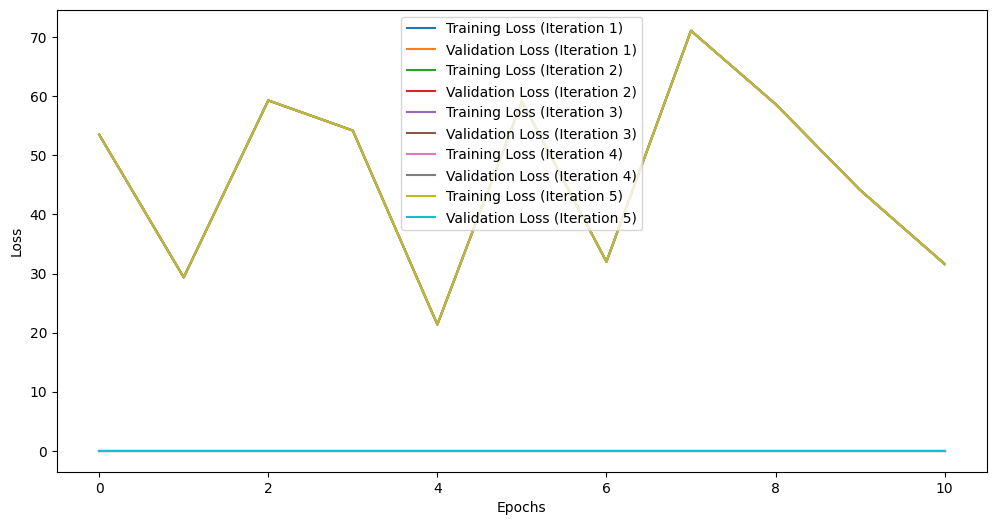

In [12]:
# plt.figure(figsize=(12, 6))
# for i in range(iteration):
#     plt.plot(history.history['loss'], label=f'Training Loss (Iteration {i+1})')
#     plt.plot(history.history['val_loss'], label=f'Validation Loss (Iteration {i+1})')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [13]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers

# dataset = np.concatenate((Control30, Concussed52), axis=0)
# labels = np.concatenate((np.zeros(len(Control30)), np.ones(len(Concussed52))))

# iteration = 5

# train_ratio = 0.8
# test_ratio = 0.2

# total_datasets = len(dataset)
# step_size = int((total_datasets - train_ratio * total_datasets) / (iteration - 1))
# test_accuracies = []
# for i in range(iteration):
#     start_idx = i * step_size
#     end_idx = int(start_idx + train_ratio * total_datasets)
#     X_train = dataset[start_idx:end_idx]
#     y_train = labels[start_idx:end_idx]
#     X_test = dataset[end_idx:]
#     y_test = labels[end_idx:]
#     input_shape = X_train.shape[1:]
#     X_train = X_train.reshape((-1,) + input_shape)
#     X_test = X_test.reshape((-1,) + input_shape)
#     print("Training data shape:", X_train.shape)
#     print("Training labels shape:", y_train.shape)
#     print("Testing data shape:", X_test.shape)
#     print("Testing labels shape:", y_test.shape)
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(16, kernel_size=(6, 6), strides=2, activation='relu', padding='same', input_shape=input_shape))
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
#     model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Flatten())
#     model.add(layers.Dense(256, activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(2, activation='softmax'))

#     learning_rate = 0.005
#     optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
#     test_loss, test_accuracy = model.evaluate(X_test, y_test)
#     print("Iteration:", i+1)
#     print("Test Accuracy:", test_accuracy)
#     test_accuracies.append(test_accuracy)

# mean_accuracy = np.mean(test_accuracies)
# std_accuracy = np.std(test_accuracies)
# print("Mean_Accuracy",mean_accuracy)
# print("Std_Accuracy",std_accuracy)


In [14]:
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt

# # Normalize the input data
# # X_train = X_train / 255.0
# # X_val = X_val / 255.0
# # X_test = X_test / 255.0
# input_shape = X_train.shape[1:]
# # Build the CNN model
# model = tf.keras.Sequential()
# model.add(layers.Conv2D(16, kernel_size=(6, 6), strides=1, activation='relu', padding='same', input_shape=input_shape))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(2, activation='softmax'))

# learning_rate = 0.001
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define the early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model with early stopping
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

# # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# val_loss, val_accuracy = model.evaluate(X_val, y_val)

# # Print the test accuracy
# print("Test Accuracy:", test_accuracy)

# # Generate training and testing accuracy
# training_accuracy = history.history['accuracy']
# testing_accuracy = history.history['val_accuracy']

# # Generate learning curve
# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']

# # Plot training and testing accuracy
# plt.plot(training_accuracy, label='Training Accuracy')
# plt.plot(testing_accuracy, label='Testing Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot learning curve
# plt.plot(training_loss, label='Training Loss')
# plt.plot(validation_loss, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
